## MD simulations of fluids

In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

### Initial positions, velocities and forces

Unlike MC simulation where the initial condition is fully specified by positin arrray in MD simulations we must also specify initial velocities which allows us to determine initial forces!

In [3]:
def IC_box(rho=0.88, N_cell=3):
    '''Function to generate initial positions of LJ fluid. here particles are ordered on a lattice with 
    number of unitcells N_cell of length L_lcell .
    ---
    rho: density of the system
    N_cell: how many repeats of close packed unit cells

    returns: position array of shape (N, 3)
    '''

    N      = 4 * N_cell ** 3      # Total number of particles 
    L_box  = (N / rho) ** (1 / 3) # length of the whole box
    L_cell = L_box / N_cell       # length of a unit cell

    pos = [[[x,  y, z], [x, 0.5 + y, 0.5 + z], [0.5 + x, y, 0.5 + z], [0.5 + x, 0.5 + y, z]] 
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    
    pos = np.array(pos).reshape((-1, 3))

    return pos * L_cell, L_box


def IC_vel(N):
    '''Genreate initial distribution of velocities from Maxwell-Botlzmann'''

    vel  = np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)

    return vel 

def IC_F(N):
    '''Generate force matrix objects to be used throughout simulation
    ---
    F:  (N, N, 3) array that contains all the forces between i, j particles in 3D
    ind: arrays of size N and N. These are indices of upper triangular matrix e.g (i, j) such that  i<j. 
    Having indices of all inter-particle forces allows us to avoid using for loops

    '''
    
    F   = np.zeros((N, N, 3))       
    I, J = np.triu_indices(N, k=1)   
    
    return F, I, J

### Inspect initial positions, forces and velocities

In [ ]:
pos, L_box = IC_box(rho=0.88, N_cell=3)

plt.scatter(pos[:, 0], pos[:,1])

In [ ]:
F, I, J = IC_F(5)

print(F.shape)
print(I)
print(J)

In [ ]:
vel = IC_vel(100)

plt.hist(vel[:,0], alpha=0.5, density=True);

### Computation of forces

- Most of the computational heavy lifting in MD simulations goes into evaluation of forces. 

- As the number of particles goes so does the need to evaluate the number of interacting pairs

- In realistic simulations neighbor lists and cutoff distances are used to minimize and keep track of smaller number of particle pairs

In [4]:
def force_update(pos):   
    '''This function is used to update the force matrix F which has been created via IC_F function earlier
    pos: (N, 3) position array is specified as input
    
    returns
    ---
    forces:
    U:    potential energy
    P:    pressure
    hist: histogram of r^2 distances
    '''

    # Compute all unique ij distances
    r_vec = pos[I] - pos[J]

    # Use min image criteria for distances
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box

    # Compute r^2
    r_sq = np.sum(r_vec**2, axis=1)

    # Compute forces 
    dUdr = -(48 / r_sq ** 7 - 24 / r_sq ** 4)

    # Compute force maxtirx containing all forces between ij particles dU/dr * dr
    F[I,J] = dUdr[:, np.newaxis] * r_vec

    # Compute total force acting on each particle (i=1,...N) 
    forces = F.sum(axis=0) - F.sum(axis=1)

    # Compute potential energy, pressure and histogram of r^2 pair distances
    U = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)

    P = np.sum(F[I,J] * r_vec)

    hist = np.histogram(r_sq, bins=30, range=(0, L_box / 2))[0]
    
    return forces, U, P, hist

### Time stepping 

In [5]:
def time_step(pos, vel, F):
    '''Update velocities, positions and forces after dt time step of integration'''

    vel += 0.5 * F * dt
    
    pos = np.mod(pos + vel * dt, L_box)

    F, pot, P, hist = force_update(pos)
    
    vel += 0.5 * F * dt
    kin = 0.5 * np.sum(vel**2)

    return pos, vel, F, pot, kin, P, hist

In [14]:
def simulate(pos, 
             vel, 
             T, 
             freq_out=50, 
             nsteps=10000):
    '''Main MD simulation loop. All of the variables and force matrix must be initialized 
    so that functions can acess them'''

    kins, pots, Ps, hists = [], [], [], []
    
    F = force_update(pos)[0]

    for t in range(nsteps):

        # Update positions, velocities, forces
        pos, vel, F, pot, kin, P, hist = time_step(pos, vel, F)

        # Scaling velocitites to keep T constant
        vel *= np.sqrt(N * 3 * T / (2 * kin))
        
        # Save thermo output
        if t % freq_out == 0:

            kins.append(kin)
            pots.append(pot)
            Ps.append(P)
            hists.append(hist)

    return np.array(kins), np.array(pots), np.array(Ps), np.mean(hists, axis=0)

### Running MD simulation

- Once again we collect all the relevant parameters of simulation in once cell to make it easy to do various exploratons

In [15]:
#------- Initalize global variables: positions, box length, velocities and Forces-------
pos, L_box     = IC_box(rho=0.88, N_cell=3)
vel            = IC_vel(N)
F, I, J        = IC_F(N)

#Run simulation
kins, pots, Ps, hist = simulate(pos, vel, T, freq_out=50, nsteps=10000)

### Analysis of MD simulation 

<ipython-input-16-6627a5d7945d>:2: RuntimeWarning: invalid value encountered in true_divide
  pair_correlation = hist / (4 * np.pi * rho * r)


Text(0, 0.5, '$g(r)$')

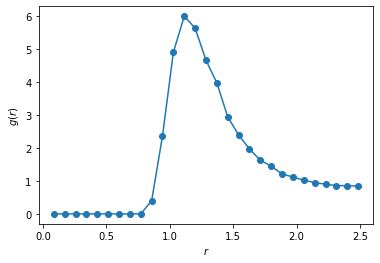

In [16]:
r = np.linspace(0, L_box / 2, 30)
pair_correlation = hist / (4 * np.pi * rho * r)

plt.plot(r, pair_correlation, '-o') 
plt.xlabel(r'$r$')  
plt.ylabel(r'$g(r)$')